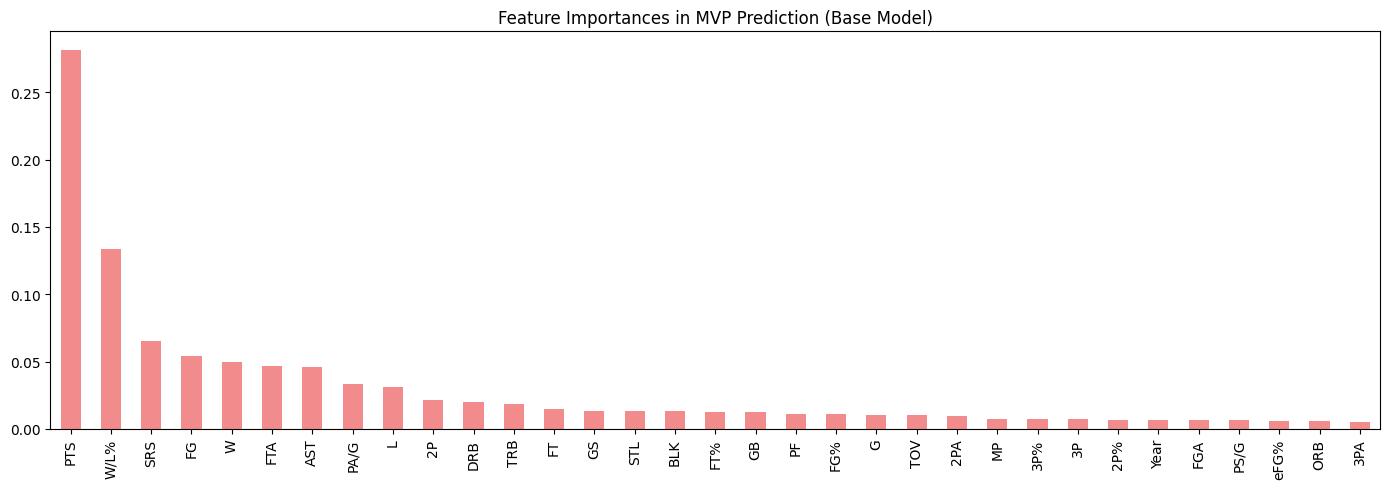

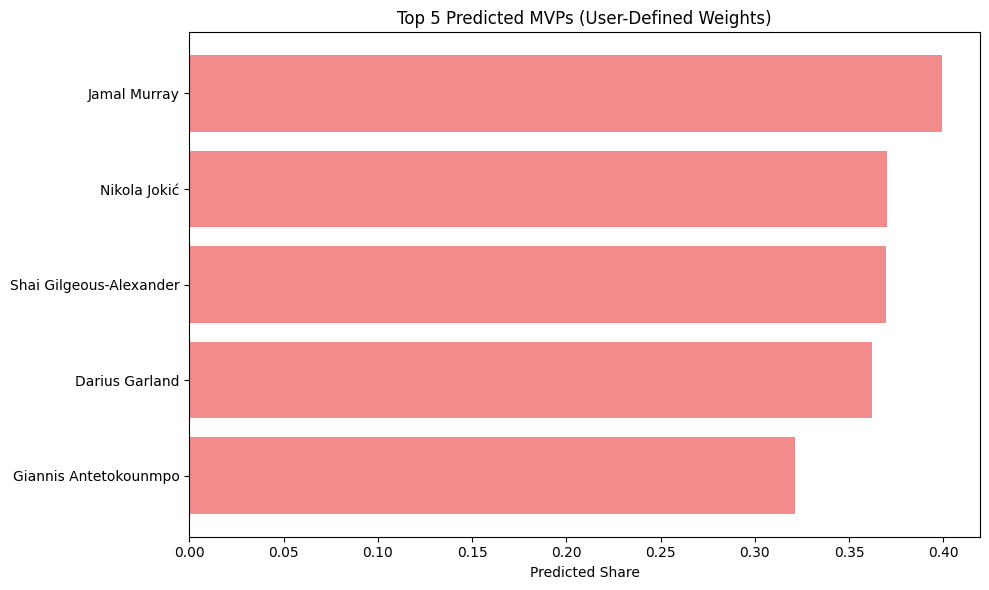

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the dataset
stats = pd.read_csv("player_mvp_stats.csv")

# Fill any NaNs with 0 (safe fallback)
stats = stats.fillna(0)

# Predictor list
predictors = ['G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
              '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
              'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year', 'W', 'L',
              'W/L%', 'GB', 'PS/G', 'PA/G', 'SRS']

# Split into train/test
train_df = stats[stats['Year'] < 2024]
test_df = stats[stats['Year'] == 2024].copy()

X_train = train_df[predictors].copy()
X_test = test_df[predictors].copy()
y_train = train_df['Share']

# Base model stat weights
base_weights = {
    'PTS': 1.0,
    'AST': 1.5,
    'TRB': 1.2,
    'BLK': 1.0
}

# Apply base weights to training and testing data
for stat, mult in base_weights.items():
    if stat in X_train.columns:
        X_train[stat] *= mult
        X_test[stat] *= mult

# Train base Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict base 2024 shares
test_df['Predicted_Share'] = model.predict(X_test)

# 🎯 USER INPUTS: Stat importance as percentages (must sum to 100)
user_input_percentages = {
    'PTS': 0,
    'AST': 60,
    'TRB': 30,
    'BLK': 10
}

# ✅ Validate sum
if sum(user_input_percentages.values()) != 100:
    raise ValueError("❌ Your weights must add up to 100.")
    
# Convert user percentages into weights based on base_weights total sum
base_sum = sum(base_weights.values())
user_weights = {
    stat: (user_input_percentages[stat] / 100) * base_sum
    for stat in user_input_percentages
}

# 🧠 Apply user weights to a copy of the 2024 test data
X_test_user = test_df[predictors].copy()
for stat, mult in user_weights.items():
    if stat in X_test_user.columns:
        X_test_user[stat] *= mult

# Predict using user model settings
test_df['User_Predicted_Share'] = model.predict(X_test_user)

# 📊 Feature Importance Plot (Base model)
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(14, 5), color='#F28C8C')
plt.title("Feature Importances in MVP Prediction (Base Model)")
plt.tight_layout()
plt.show()

top_5_user = test_df.sort_values(by='User_Predicted_Share', ascending=False).head(5)

plt.figure(figsize=(10, 6))
plt.barh(top_5_user['Player'], top_5_user['User_Predicted_Share'], color='#F28C8C')
plt.xlabel("Predicted Share")
plt.title("Top 5 Predicted MVPs (User-Defined Weights)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

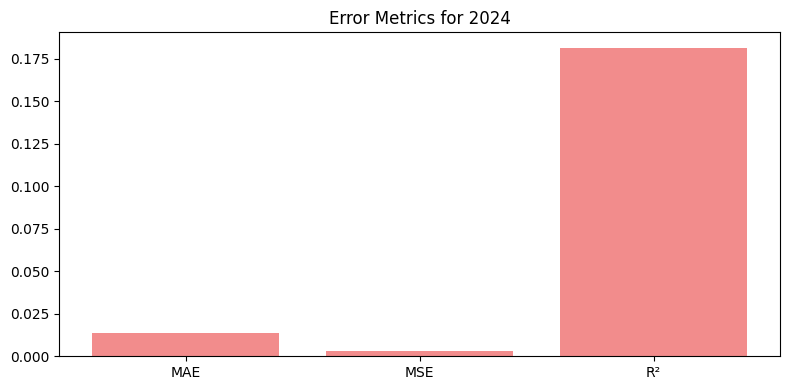

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Apply user-defined weights to training data
X_train_user = train_df[predictors].copy()
for stat, mult in user_weights.items():
    if stat in X_train_user.columns:
        X_train_user[stat] *= mult

# Predict with user-defined weights
y_pred_user_train = model.predict(X_train_user)
y_true_train = train_df['Share']

# Error metrics for training data (user-defined model)
mae_user = mean_absolute_error(y_true_train, y_pred_user_train)
mse_user = mean_squared_error(y_true_train, y_pred_user_train)
r2_user = r2_score(y_true_train, y_pred_user_train)

# 📊 Bar chart
plt.figure(figsize=(8, 4))
plt.bar(['MAE', 'MSE', 'R²'], [mae_user, mse_user, r2_user], color='#F28C8C')
plt.title("Error Metrics for 2024")
plt.tight_layout()
plt.show()


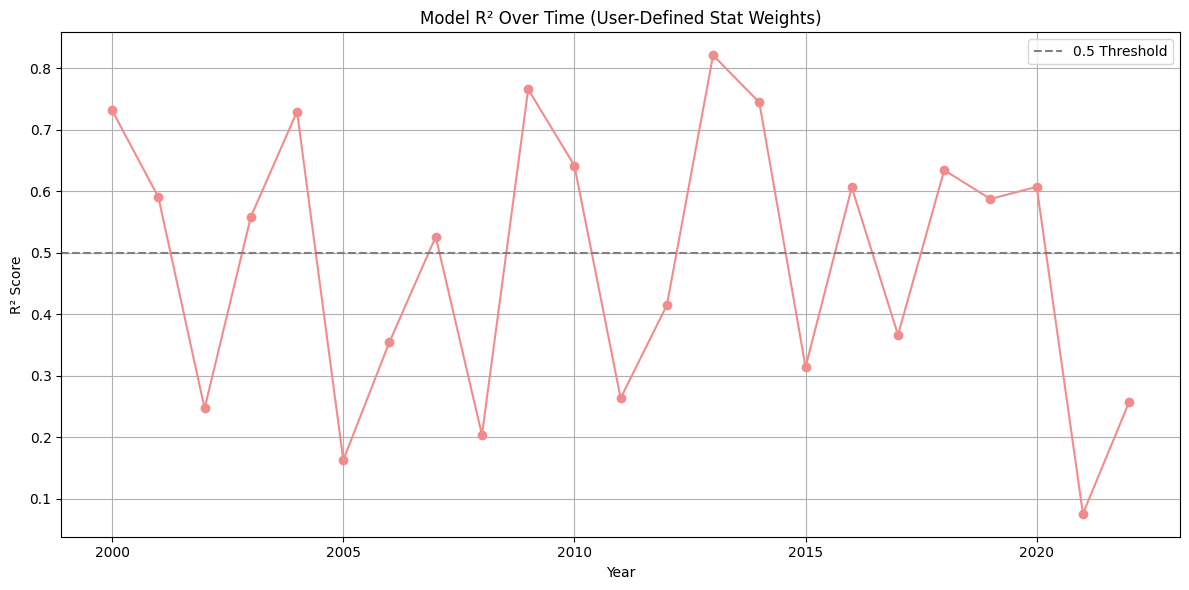

In [3]:
# Convert user percentages into weights proportional to base weights
base_sum = sum(base_weights.values())
user_weights = {
    stat: (user_input_percentages[stat] / 100) * base_sum
    for stat in user_input_percentages
}

# 🧪 Backtest with user weights
user_backtest_years = range(2000, 2023)
user_results = []

for year in user_backtest_years:
    train_df_bt = stats[stats['Year'] < year]
    test_df_bt = stats[stats['Year'] == year].copy()

    if train_df_bt.empty or test_df_bt.empty:
        continue

    X_train_bt = train_df_bt[predictors].copy()
    y_train_bt = train_df_bt['Share']
    X_test_bt = test_df_bt[predictors].copy()
    y_test_bt = test_df_bt['Share']

    # Apply user weights
    for stat, mult in user_weights.items():
        if stat in X_train_bt.columns:
            X_train_bt[stat] *= mult
            X_test_bt[stat] *= mult

    # Train model and predict
    user_model = RandomForestRegressor(n_estimators=100, random_state=42)
    user_model.fit(X_train_bt, y_train_bt)
    y_pred_bt = user_model.predict(X_test_bt)

    # Evaluate
    mae = mean_absolute_error(y_test_bt, y_pred_bt)
    mse = mean_squared_error(y_test_bt, y_pred_bt)
    r2 = r2_score(y_test_bt, y_pred_bt)

    user_results.append({'Year': year, 'MAE': mae, 'MSE': mse, 'R2': r2})

# Convert to DataFrame
user_results_df = pd.DataFrame(user_results)

# 📈 Plot R² over time for user model
plt.figure(figsize=(12, 6))
plt.plot(user_results_df['Year'], user_results_df['R2'], marker='o', linestyle='-', color='#F28C8C')
plt.axhline(0.5, color='gray', linestyle='--', label='0.5 Threshold')
plt.title("Model R² Over Time (User-Defined Stat Weights)")
plt.xlabel("Year")
plt.ylabel("R² Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
